In [1]:
import os
import glob

In [2]:
import numpy as np
from matplotlib.pyplot import *

In [3]:
import TimeTagger as TT
from TimeTagger import Flim, TimeTagStream, createTimeTaggerVirtual, EventGenerator, Countrate,ConstantFractionDiscriminator, DelayedChannel

In [4]:
#from tqdm.notebook import tqdm
from fastprogress.fastprogress import progress_bar,master_bar
import tifffile as tf

In [5]:
filename = 'C:\\Users\\lociuser\\Documents\\UserData\\Jenu\\BB_data\\CYCLE_000001_RAWDATA_000034'

In [6]:
tagformat = np.dtype([
    # TimeTag = 0, Error = 1, OverflowBegin = 2, OverflowEnd = 3, MissedEvents = 4
    ('type', 'u1'),
    # ('reserved',      'i1'),
    ('missed_events', '<u2'),
    ('channel', '<i4'),
    ('time', '<i8'),], align=True)

In [ ]:
foldername = r'D:\Data\BrianBurkel\TSeries-ms499_NADH_FLIM_780_230620-001'
filelist = glob.glob(os.path.join(foldername,'CYCLE_*_RAWDATA_*'))
len(filelist) # 46 GB

In [ ]:
os.chdir(foldername)

In [116]:
mb = master_bar(filelist)

for filename in mb:
    
    with open(filename,'rb') as fid:
        data_ = np.frombuffer(fid.read(), dtype=tagformat)

    tm = (data_[-1]['time'] - data_[0]['time'])/1e12
    print(f'{os.path.split(filename)[-1]} || {tm:.2f} secs',end='')
    print('|| NONTAGGED' ,len(np.where(data_['type']!=0)[0]),end='')
    print('|| MISSED' ,len(np.where(data_['missed_events']!=0)[0]),end='')
    px_e = len(np.where(data_['channel']==2)[0])
    print('|| PIXELS',px_e,end='')
    ch1_e = len(np.where(data_['channel']==1013)[0])
    print('|| CH1',ch1_e,end='')
    ch2_e = len(np.where(data_['channel']==1014)[0])
    print('|| CH2',ch2_e,end='\n')
    
    channel_numbers, counts = np.unique(data_["channel"], return_counts=True)
    for i in zip(channel_numbers,counts):
        print(i, end='||')
    print()
    
    sdts=[]
    current_pixel=0
    arr1=[]#np.zeros(512*512)
    arr2=[]#np.zeros(512*512)
    frm_pixel=[0]
    
    for ix,photon_event in progress_bar(enumerate(data_),total=len(data_), parent=mb):
        
        if current_pixel==0:
            times1 = []
            times2 = []
            
        if photon_event['channel']==3: ## LASER SYNC
            prev_event=None
            prev_step=1
            while not (prev_event):
                prev_ = data_[ix-prev_step]
                if (prev_['channel']==1013):
                    prev_event=prev_    
                    #px1.append((photon_event,prev_))   
                    times1.append(prev_['time']- photon_event['time'])
                if (prev_['channel']==1014):        
                    prev_event=prev_    
                    #px2.append((photon_event,prev_))
                    times2.append(prev_['time']- photon_event['time'])
                prev_step+=1
                
        if photon_event['channel']==2: ## PIXEL MARKER
            current_pixel+=1
            if times1:
                arr1.append(times1)
            else:
                arr1.append([-12501])
            if times2:
                arr2.append(times2)
            else:
                arr2.append([-12501])
            times1 = []
            times2 = []
            
        #frm = current_pixel/(512*512)
        if (current_pixel%(512*512)==0)&(current_pixel>frm_pixel[-1]):        ## FRAME MARKER
            #print(ix,f'\t {ix/len(data_):.2f}',photon_event, current_pixel)
            sdt1=np.zeros([512*512,256])
            sdt2=np.zeros([512*512,256])
            bin1 = int(12500/256)
            for a1x,a in enumerate(arr1):
                if a:
                    tsx=[a1//bin1 for a1 in a if (a1//bin1)>-256]
                    sdt1[a1x,tsx]+=1
            for a1x,a in enumerate(arr2):
                if a:
                    tsx=[a1//bin1 for a1 in a if (a1//bin1)>-256]
                    sdt2[a1x,tsx]+=1

            arr1=[]#np.zeros(512*512)
            arr2=[]#np.zeros(512*512)
            sdts.append((sdt1,sdt2))

            frm_pixel.append(current_pixel)
    
    timelapse=[]
    for ix,(sdt1x,sdt2x) in progress_bar(enumerate(sdts),total=len(sdts), parent=mb):
        #print(sdt1x.sum(),sdt2x.sum())
        
        sdt1a = sdt1x.reshape([512,512,256]).transpose([2,0,1])
        sdt2a = sdt2x.reshape([512,512,256]).transpose([2,0,1])

        tf.imwrite(f'{filename}_ch1_f{ix:>02}.tif',sdt1a.astype(np.uint16))
        tf.imwrite(f'{filename}_ch2_f{ix:>02}.tif',sdt2a.astype(np.uint16))
        
        timelapse.append([sdt1a.sum(),sdt2a.sum()])
        
    print(frm_pixel[-1],' of ',px_e, '|| Frames=', len(sdts), len(data_))
    print(f'CH1 = {100*(np.array(timelapse)[:,0].sum())/(ch1_e):.1f}% || CH2 = {100*(np.array(timelapse)[:,1].sum())/(ch2_e):.1f}%')
    print(np.array(timelapse)[0,0], '|'.join([f'{(1-k)*100:.1f}' for k in np.array(timelapse)[:,0]/(np.array(timelapse)[0,0])]))
    print(np.array(timelapse)[0,1], '|'.join([f'{(1-k)*100:.1f}' for k in np.array(timelapse)[:,1]/(np.array(timelapse)[0,1])]))
    print()
    del sdts
    del data_

CYCLE_000001_RAWDATA_000034 || 39.20 secs|| NONTAGGED 0|| MISSED 0|| PIXELS 8388716|| CH1 6627869|| CH2 5039643
(-5, 5065259)||(-4, 6628224)||(1, 1)||(2, 8388716)||(3, 11668186)||(4, 6628098)||(5, 5065332)||(1013, 6627869)||(1014, 5039643)||
8388608  of  8388716 || Frames= 32 55111328
CH1 = 98.1% || CH2 = 97.7%
192731.0 0.0|-2.7|-3.9|-5.0|-5.8|-5.8|-5.1|-6.3|-5.9|-5.1|-6.1|-5.4|-5.0|-5.9|-5.1|-5.9|-5.4|-6.4|-6.6|-5.8|-5.9|-6.0|-6.0|-5.8|-5.6|-5.9|-6.1|-5.2|-5.4|-6.0|-6.3|-5.5
148401.0 0.0|-2.3|-2.8|-3.6|-4.2|-4.2|-4.3|-4.1|-4.0|-4.5|-4.0|-4.1|-3.4|-3.9|-3.1|-3.8|-3.8|-3.9|-4.0|-3.9|-3.8|-4.1|-3.8|-4.0|-3.9|-3.6|-3.6|-3.8|-3.8|-3.7|-3.5|-3.6

CYCLE_000001_RAWDATA_000035 || 38.52 secs|| NONTAGGED 0|| MISSED 0|| PIXELS 8390121|| CH1 5265453|| CH2 4506213
(-5, 4531565)||(-4, 5265651)||(1, 1)||(2, 8390121)||(3, 9781752)||(4, 5265594)||(5, 4531602)||(1013, 5265453)||(1014, 4506213)||
8388608  of  8390121 || Frames= 32 47537952
CH1 = 98.5% || CH2 = 97.8%
160514.0 0.0|-1.3|-0.5|-1.9|-2.2|-2.0|

In [48]:
#print(current_pixel)
#print(''.join(str(np.array(timelapse)[:,0])))
#print(np.array(timelapse)[:,1])

In [102]:
import time

In [106]:
mb1 = master_bar(range(3))

for a in mb1:
    for b in progress_bar(range(10), parent=mb1):
        time.sleep(0.1)
    for b1 in progress_bar(range(20), parent=mb1):
        time.sleep(0.05)
        

In [108]:
all_e =47406912


In [109]:
(px_e+(2*(ch1_e+ch2_e)))/all_e

0.5755491941765791

In [95]:
{100*(np.array(timelapse)[:,0].sum())/(ch1_e):.1f}

160514.0

In [96]:
#(5126916-5265453)/5265453
px_e = len(np.where(data_['channel']==2)[0])
px_e

8390121

In [88]:
#8388716/(512*512)
ch1_e= 5265453

In [99]:
current_pixel

8390121

In [24]:
tl=[[1,2],[11,21],[12,2]]


[ 2 21  2]


In [121]:
fl = glob.glob(r'D:\Data\BrianBurkel\TSeries-ms499_NADH_FLIM_780_230620-001\CYC*ch1*.tif')
len(fl)

2464

In [125]:
fl = glob.glob(r'D:\Data\BrianBurkel\TSeries-ms499_NADH_FLIM_780_230620-001\CYC*ch2*.tif')
len(fl)

2464

In [127]:
fl = glob.glob(r'D:\Data\BrianBurkel\TSeries-ms499_NADH_FLIM_780_230620-001\CYC*.tif')
len(fl)

4928

In [128]:
import pathlib

In [129]:
import shutil

In [131]:
for fn in progress_bar(fl):
    shutil.move(fn,os.path.join('D:\\Data\\BrianBurkel\\split',pathlib.Path(fn).name))

In [119]:
os.getcwd()

'D:\\Data\\BrianBurkel\\split'

In [117]:
os.chdir(r'D:\Data\BrianBurkel\split')

In [118]:
cy2_ch2 = glob.glob('SUM*_000002*_ch2*.tif')
print(len(cy2_ch2))
for ix,fn in enumerate(cy2_ch2):
    data = tf.imread(fn)
    plot(ix,data.sum(),'or')

0


32


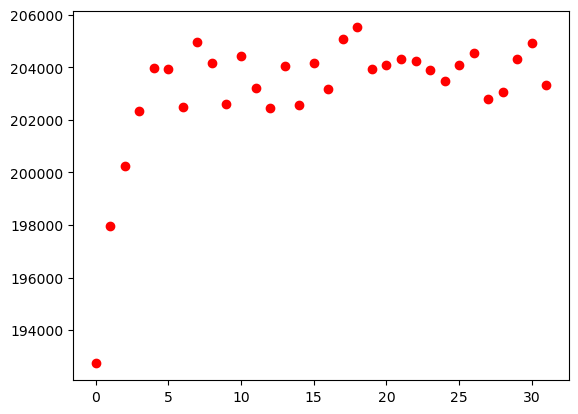

In [134]:
cy2_ch2 = glob.glob('CYCLE_000001*34*_ch1*.tif')
print(len(cy2_ch2))
x= np.zeros([512,512])
for ix,fn in enumerate(cy2_ch2):
    data = tf.imread(fn)
    plot(ix,data.sum(),'or')
    x= x + data.sum(0)

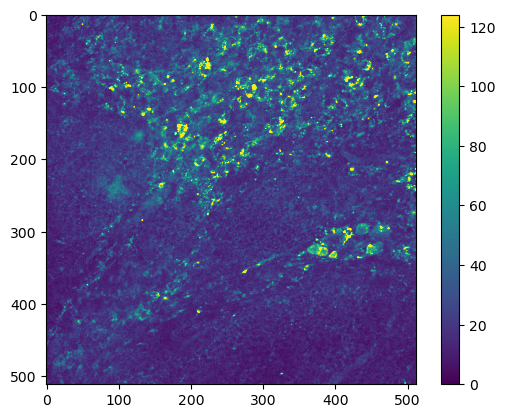

In [138]:
imshow(x,vmax=x.mean()*5)
colorbar()